# Wind Data Visualization

__Wind Data Source: [ERA5 climate data from Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/search?text=ERA5&type=dataset )__  
The wind data in this project comes from the 'ERA5 monthly averaged data on single levels from 1940 to present' dataset, specifically the 10m u-component of wind and 10m v-component of wind.  
The time period will be 2022 yearly data, and the area of interest will be Lake Erie.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
from matplotlib import pyplot as plt
import datashader as ds
import imageio

### Step 1: Read the .nc file downloaded from the ERA5 website and calculate wind strength

Read .nc file downloaded from [Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/search?text=ERA5&type=dataset)

In [2]:
windnc = xr.open_dataset('./data/ERA5climate4.nc')  

Extract latitude and longitude data of each point

In [3]:
lat = windnc.latitude
lon = windnc.longitude

Extract wind uv data

In [4]:
wind_u = windnc.u10
wind_v = windnc.v10

Calculate wind strength (m/s) based on wind uv data

In [5]:
WS = np.sqrt(wind_u**2 + wind_v**2)

### Step 2: plot wind field map for each month in 2022 and generate a gif

Read the Lake Erie shapefile extracted from [USGS National Hydrography Dataset](https://www.sciencebase.gov/catalog/item/62c6050cd34eeb1417baff15) and change it to the same projection as wind data (CRS 4326)

In [6]:
lake = gpd.read_file("./data/LakeErie")

In [7]:
lake4326 = lake.to_crs(epsg=4326)

__Define a function to collect the plot for each month__  
The plot contains three components: the wind field map (array array), the wind strength map (color), and Lake Erie location (shape).  
The wind field map is generated through vector calculation.  
The wind strength map is generated through each point's relationship to its neighbors.  

In [8]:
# Have a list of month names for the function to use
monthlist = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

In [9]:
def plot_wind_by_month(month):
    """Plot wind field map for each month in 2022"""
    fig, ax = plt.subplots(figsize=(10,6))

    # Wind strength map
    cf = plt.contourf(lon,lat,WS[month,:,:], levels=15, cmap='rainbow', alpha=0.8)
    
    # lake Erie shape
    lake4326.plot(ax=plt.gca(), edgecolor='#25408F', facecolor='none', linewidth=0.5)
    
    # Wind field map with labels
    Q = plt.quiver(lon,lat,wind_u[month,:,:],wind_v[month,:,:], scale_units='xy', scale=4, width=0.0014, color='white')
    qk = plt.quiverkey(Q, 
                  1, 1.02, 
                   1,str(1)+' m/s',   
                   labelpos='E',                
                   coordinates='axes',
                   color='black'
                   )

    # style adjustments
    cb = plt.colorbar(cf, fraction=0.0235, pad=0.03)
    cb.set_label('m/s',  fontsize=11)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Wind Field Map of {monthlist[month]}')

    # prepare for imageio
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    return image

Use the function above to see the wind strenghth for each month and generate a gif for the wind visualization

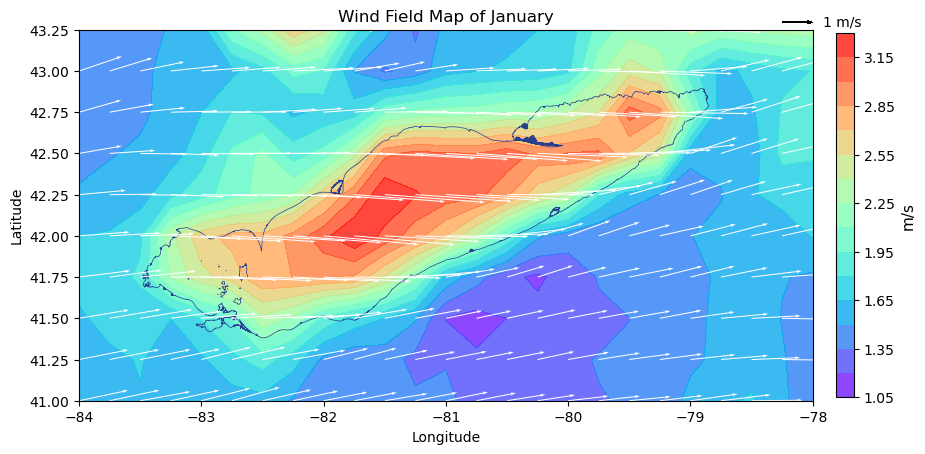

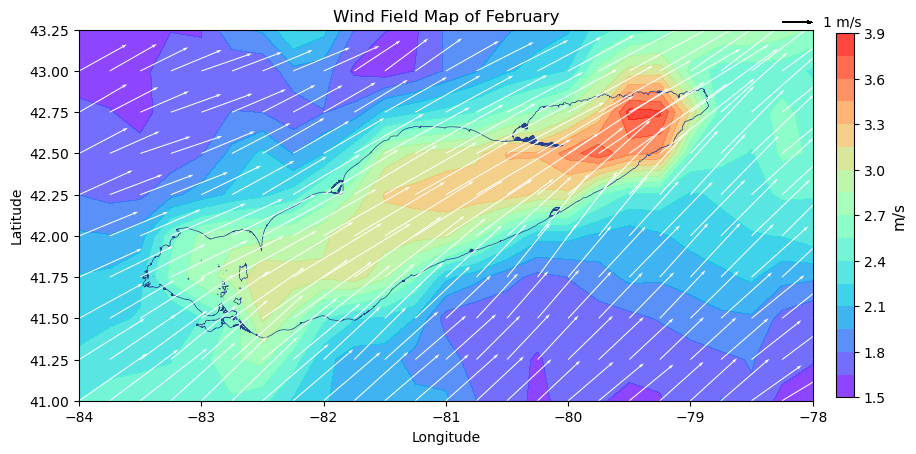

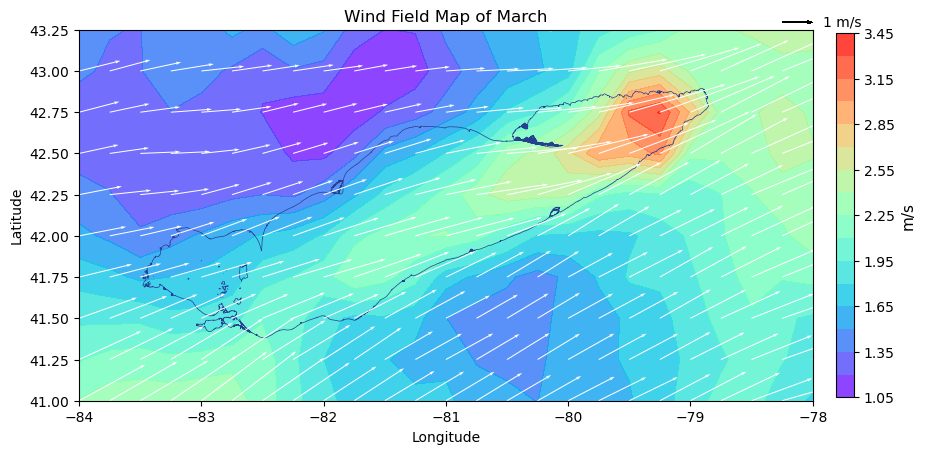

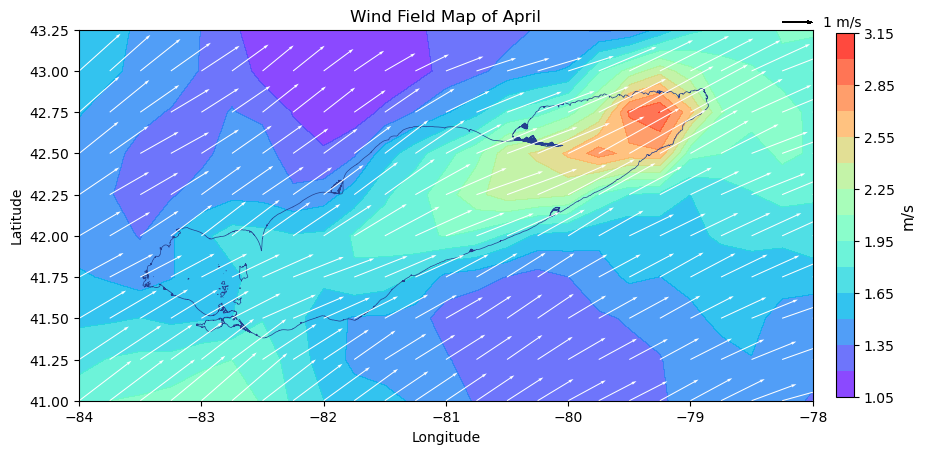

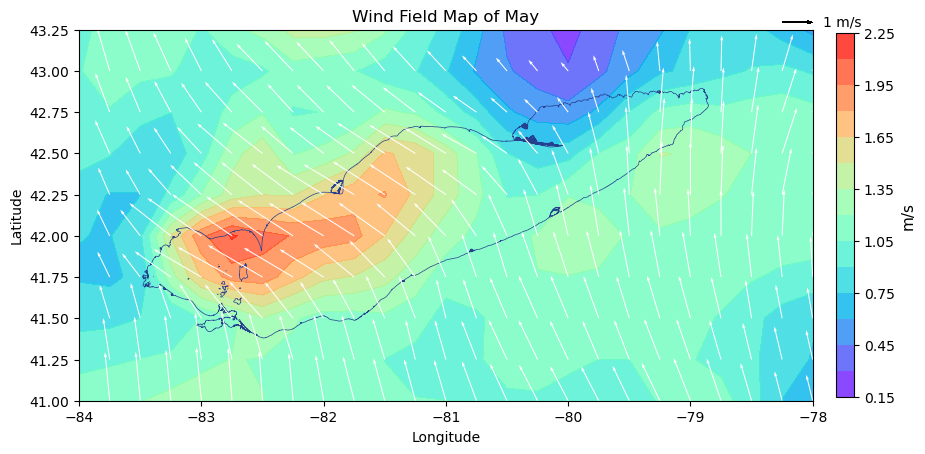

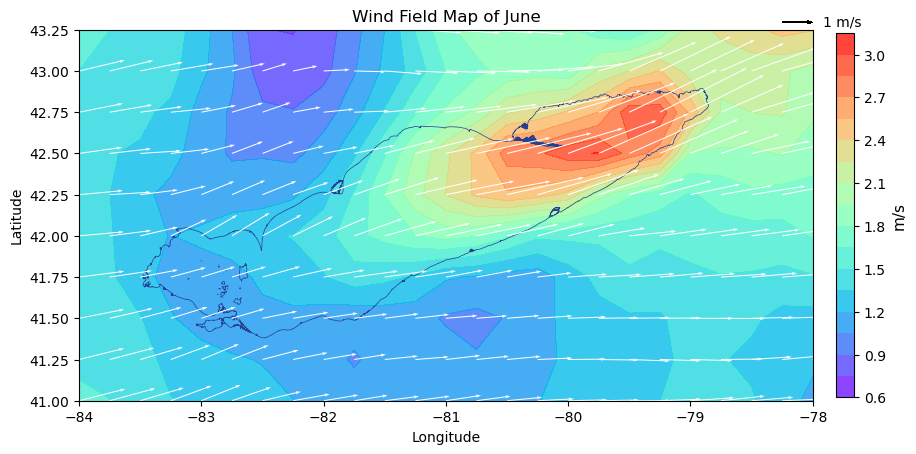

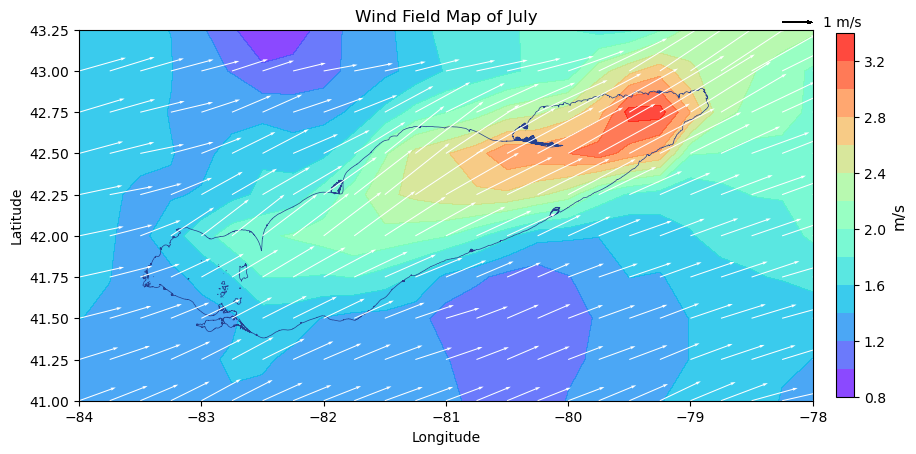

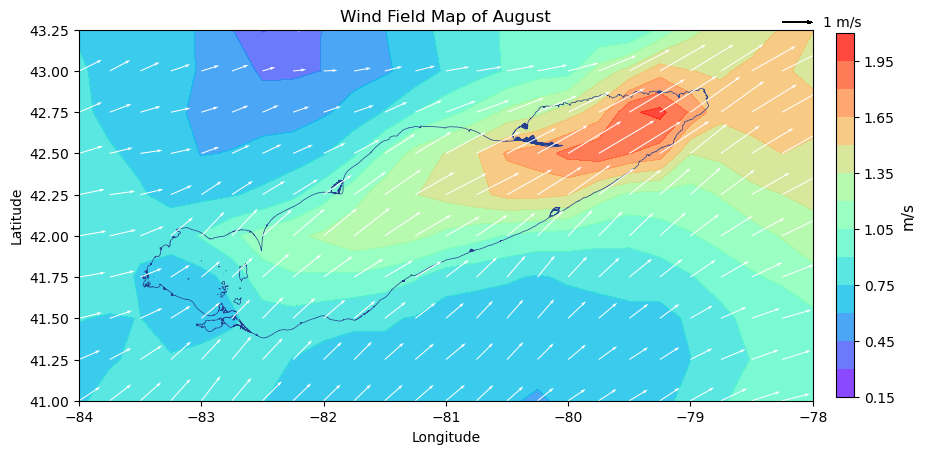

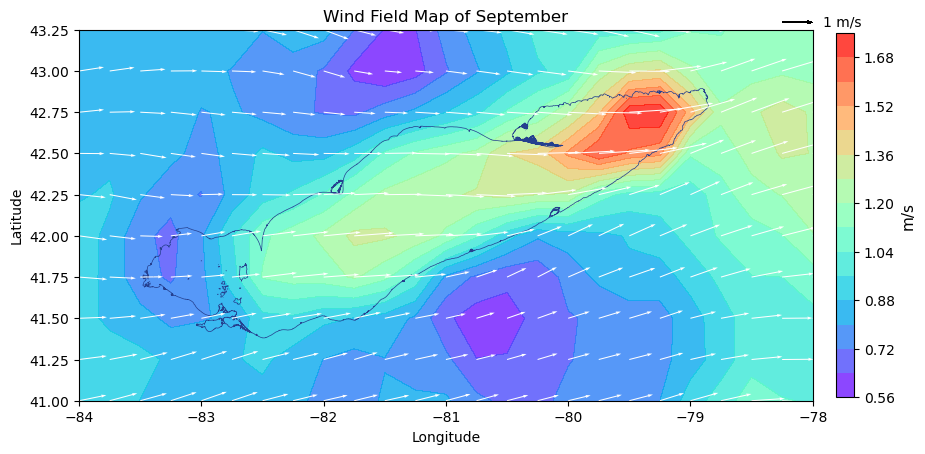

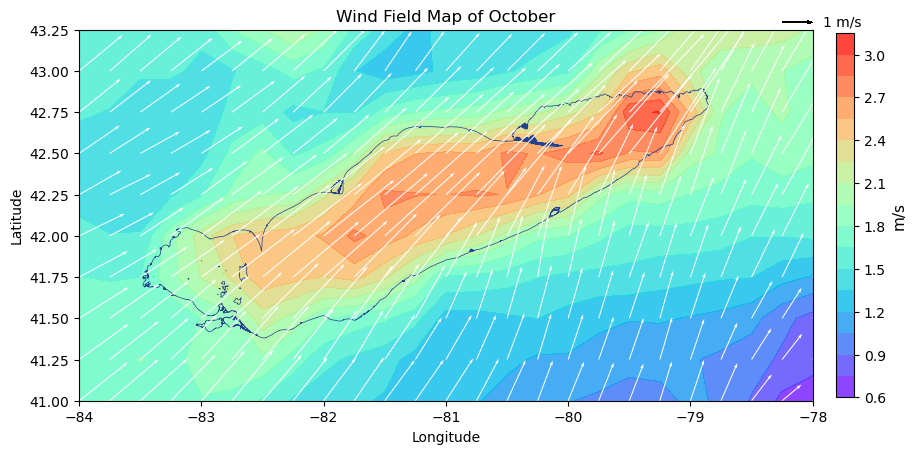

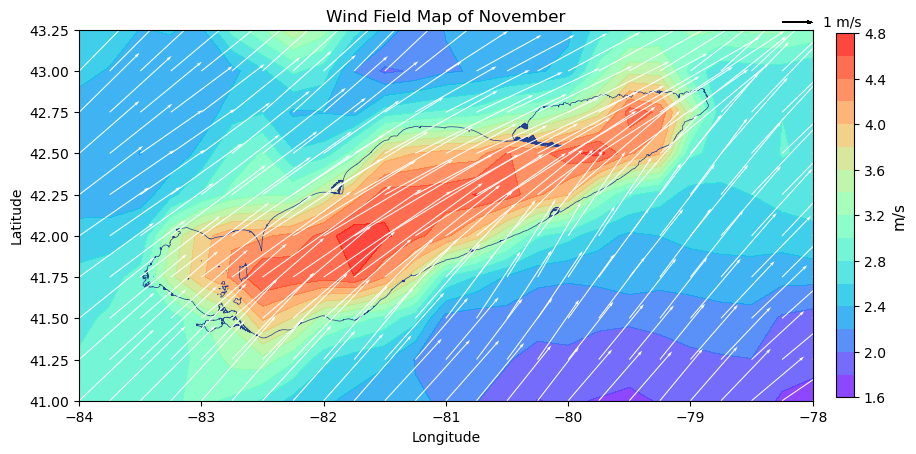

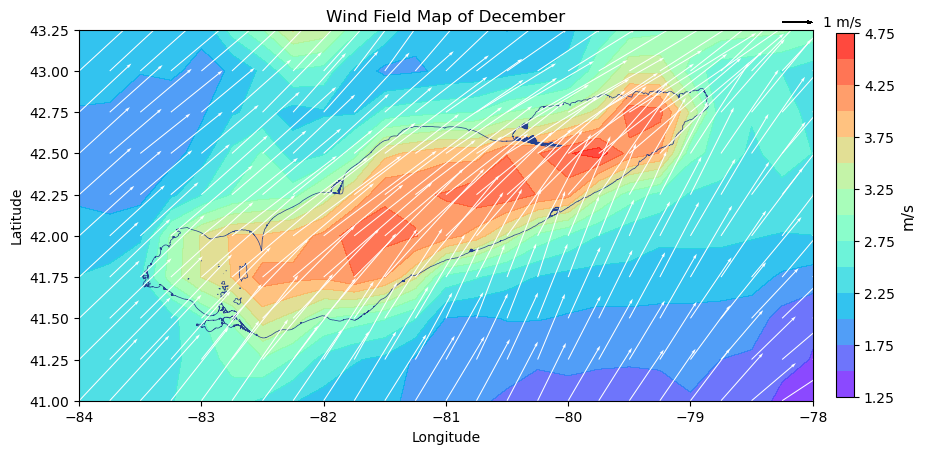

In [10]:
imgs = []
for month in range(12):
    img = plot_wind_by_month(month)
    imgs.append(img)

# Combing the images for each month into a single GIF
imageio.mimsave("wind-field.gif", imgs, duration=1000)

The gif generated above does not have infinite loop, so [Onlinegiftools](https://onlinegiftools.com/change-gif-loop-count) can help change that property  
__The final visualization is below:__  
<img src="../images/wind-field-infinite.gif" width=1000></img>

### Step 3: Analyze the result

__Result:__  
The gif works smoothly and clearly displays the wind change within 2022. The prevailing wind for Lake Erie is southwest, which is because of the typical seiche pattern. Because all the vectors of the wind field map are on the same scale, we can see that Lake Erie has severely larger wind in the winter.  
__Event:__  
The dominant southwest wind usually causes much damage to residents near the coastline in winter. Historic winter storms dumped 50 inches of snow per year in the region. In [December 2022](https://www.foxweather.com/learn/what-is-a-seiche), blizzards and seiche killed 50 people, including 27 in Buffalo, and created a catastrophic blanket of ice across the city.  
__Compare:__  
The gif result can reflect the event above. In November and December, the wind field arrays are much longer than the arrays in other months.
